
# **Predicting Health Risk Categories from BRFSS Data**

**Author:** *Puspita Chowdhury*  
**Dataset:** CDC Behavioral Risk Factor Surveillance System (BRFSS)  
**Official Source:** https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data

**Overview**  
I build a leak‑safe classification workflow to predict health risk categories using BRFSS‑style survey data. I focus on:  
- clear **EDA** to understand distributions, class balance, and correlations,  
- careful **data cleaning** (removing variables that would leak the label), and  
- reproducible **scikit‑learn Pipelines** so preprocessing and modeling are fit only on the training split.

**How loading works**  
If a DataFrame named `df` already exists in memory, I use it directly. Otherwise, I load from a CSV (e.g., `/mnt/data/brfss.csv`) or the paths referenced in this notebook. I also standardize column names (e.g., trimming whitespace) to avoid subtle errors.


In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns




## Load BRFSS Dataset

This block loads the BRFSS CSV file into a pandas DataFrame (`df`) and previews the first few rows to confirm the data loaded correctly.

In [2]:

df = pd.read_csv('/Users/puspita/Library/CloudStorage/OneDrive-YeshivaUniversity/Msc AI Predictive models/final project/archive/2015.csv').sample(10000, random_state = 50)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


## Dataset Dimensions

This block checks the number of rows and columns in the dataset to confirm the working sample size.

In [3]:
df.shape

(10000, 330)

In [4]:
df.columns.tolist()

['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'DISPCODE',
 'SEQNO',
 '_PSU',
 'CTELENUM',
 'PVTRESD1',
 'COLGHOUS',
 'STATERES',
 'CELLFON3',
 'LADULT',
 'NUMADULT',
 'NUMMEN',
 'NUMWOMEN',
 'CTELNUM1',
 'CELLFON2',
 'CADULT',
 'PVTRESD2',
 'CCLGHOUS',
 'CSTATE',
 'LANDLINE',
 'HHADULT',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'POORHLTH',
 'HLTHPLN1',
 'PERSDOC2',
 'MEDCOST',
 'CHECKUP1',
 'BPHIGH4',
 'BPMEDS',
 'BLOODCHO',
 'CHOLCHK',
 'TOLDHI2',
 'CVDINFR4',
 'CVDCRHD4',
 'CVDSTRK3',
 'ASTHMA3',
 'ASTHNOW',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'HAVARTH3',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3',
 'DIABAGE2',
 'SEX',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'NUMHHOL2',
 'NUMPHON2',
 'CPDEMO1',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME2',
 'INTERNET',
 'WEIGHT2',
 'HEIGHT3',
 'PREGNANT',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'SMOKDAY2',
 'STOPSMK2',
 'LASTSMK2',
 'USENOW3',
 'ALCDAY5',
 'AVEDRNK2',
 'DRNK3GE

## Column Inventory

This block lists all column names so i can inspect available variables and plan cleaning/feature selection.

## column rename

In [5]:
#  Create a full rename dictionary
rename_dict = {
    # Household & demographic
    '_PSU': 'PrimarySamplingUnit',
    'CTELENUM': 'HasTelenumber',
    'PVTRESD1': 'PrivateResidence',
    'STATERES': 'StateResidence',
    'CELLFON3': 'HasCellPhone',
    'NUMADULT': 'NumAdultsInHH',
    'NUMMEN': 'NumMenInHH',
    'NUMWOMEN': 'NumWomenInHH',
    'PERSDOC2': 'HasPersonalDoctor',
    'MEDCOST': 'CouldNotAffordMedicalCare',
    'CHECKUP1': 'LastRoutineCheckup',
    'BPHIGH4': 'EverToldHighBloodPressure',
    'BLOODCHO': 'EverToldHighCholesterol',
    'CHOLCHK': 'CholesterolCheckedRecently',
    'TOLDHI2': 'EverToldHighCholesterol2',
    'CVDINFR4': 'EverHadHeartAttack',
    'CVDCRHD4': 'EverHadCoronaryDisease',
    'CVDSTRK3': 'EverHadStroke',
    'ASTHMA3': 'EverHadAsthma',
    'CHCSCNCR': 'EverHadSkinCancer',
    'CHCOCNCR': 'EverHadOtherCancer',
    'CHCCOPD1': 'EverHadCOPD',
    'HAVARTH3': 'EverHadArthritis',
    'ADDEPEV2': 'EverHadDepression',
    'CHCKIDNY': 'EverHadKidneyDisease',
    'DIABETE3': 'EverHadDiabetes',
    'RENTHOM1': 'HomeOwnership',
    'NUMHHOL2': 'NumHouseholdMembersTelephone',
    'CPDEMO1': 'CoreDemographics',
    'VETERAN3': 'VeteranStatus',
    'EMPLOY1': 'EmploymentStatus',
    'CHILDREN': 'NumChildren',
    'INCOME2': 'IncomeCategory',
    'INTERNET': 'InternetAccess',

    # Physical & health measurements
    'WEIGHT2': 'WeightInPounds',
    'HEIGHT3': 'HeightInInches',
    'HTIN4': 'HeightInInchesAlt',
    'HTM4': 'HeightInCm',
    'WTKG3': 'WeightInKg',
    '_BMI5': 'BMIx100',
    '_BMI5CAT': 'BMICategory',
    '_RFBMI5': 'HealthyBMIIndicator',

    # Functional limitations
    'QLACTLM2': 'ActivityLimitationDays',
    'USEEQUIP': 'UsesSpecialEquipment',
    'BLIND': 'BlindOrSeriousVisionTrouble',
    'DECIDE': 'DifficultyConcentrating',
    'DIFFWALK': 'DifficultyWalking',
    'DIFFDRES': 'DifficultyDressing',
    'DIFFALON': 'DifficultyDoingAlone',

    # Lifestyle factors
    'SMOKE100': 'EverSmoked100Cigarettes',
    'USENOW3': 'CurrentSmokerStatus',
    'ALCDAY5': 'AlcoholDaysPerMonth',
    'FRUITJU1': 'FruitJuiceConsumption',
    'FRUIT1': 'FruitConsumption',
    'FVBEANS': 'BeansConsumption',
    'FVGREEN': 'GreenVegetableConsumption',
    'FVORANG': 'OrangeVegetableConsumption',
    'VEGETAB1': 'VegetableConsumption',

    # Exercise
    'EXERANY2': 'AnyExercise',
    'EXRACT11': 'ActivityType1',
    'EXEROFT1': 'Activity1Frequency',
    'EXERHMM1': 'Activity1Minutes',
    'EXRACT21': 'ActivityType2',
    'STRENGTH': 'StrengthTraining',
    'PhysicalActivityIndicator': 'PhysicalActivityIndicator',
    'PhysicalActivityIndex': 'PhysicalActivityIndex',

    # Safety & immunization
    'SEATBELT': 'SeatbeltUseFrequency',
    'FLUSHOT6': 'FluShotReceived',
    'PNEUVAC3': 'PneumoniaVaccineReceived',
    'HIVTST6': 'EverTestedForHIV',
    '_RFSEAT3': 'SeatbeltUsageFlag',
    'HIVTested': 'HIVTested',

    # Metadata
    'QSTVER': 'QuestionnaireVersion',
    'QSTLANG': 'QuestionnaireLanguage',
    'MSCODE': 'MetropolitanStatusCode',
    '_STSTR': 'StratumID',
    '_STRWT': 'StratumWeight',
    '_RAWRAKE': 'RawRakeWeight',
    '_WT2RAKE': 'FinalWeight',
    '_CHISPNC': 'HispanicFlag',
    '_DUALUSE': 'LandlineCellFlag',
    '_DUALCOR': 'PhoneCorrectionFactor',
    '_LLCPWT': 'LLCPWeight',

    # Derived risk indicators
    '_HCVU651': 'HealthcareCoverageUnder65',
    '_RFHYPE5': 'HighBloodPressureRisk',
    '_CHOLCHK': 'CholesterolCheckStatus',
    '_RFCHOL': 'HighCholesterolRisk',
    '_MICHD': 'HeartDiseaseRisk',
    '_LTASTH1': 'LongTermAsthmaStatus',
    '_CASTHM1': 'CurrentAsthmaStatus',
    '_ASTHMS1': 'AsthmaSymptomControl',
    '_DRDXAR1': 'DoctorDiagnosedArthritis',

    # Demographic grouping
    '_PRACE1': 'PrimaryRaceCode',
    '_MRACE1': 'MultiRaceCode',
    '_HISPANC': 'HispanicOrigin',
    '_RACE': 'RaceCategory',
    '_RACEG21': 'RaceGroup2',
    '_RACEGR3': 'RaceGroup3',
    '_RACE_G1': 'RaceGroupGeneral',
    'AgeGroup5Yr': 'AgeGroup5Yr',
    '_AGE65YR': 'Age65OrOlder',
    '_AGE80': 'Age80OrOlder',
    '_AGE_G': 'AgeGroupGeneral',
    '_EDUCAG': 'EducationCategory',
    '_INCOMG': 'IncomeCategoryGrouped',

    # Smoking & alcohol
    '_SMOKER3': 'SmokingStatus',
    '_RFSMOK3': 'CurrentSmokerFlag',
    'DRNKANY5': 'AnyAlcoholPast30Days',
    'DROCDY3_': 'AlcoholicDrinksPerDay',
    '_RFBING5': 'BingeDrinkingFlag',
    '_DRNKWEK': 'WeeklyDrinks',
    '_RFDRHV5': 'HeavyDrinkerFlag',

    # Nutrition (derived)
    'FTJUDA1_': 'FruitJuicePerDay',
    'FRUTDA1_': 'FruitPerDay',
    'BEANDAY_': 'BeansPerDay',
    'GRENDAY_': 'GreensPerDay',
    'ORNGDAY_': 'OrangeVegPerDay',
    'VEGEDA1_': 'VegetablesPerDay',
    '_MISFRTN': 'MissingFruitDataFlag',
    '_MISVEGN': 'MissingVegDataFlag',
    '_FRTRESP': 'FruitResponseValid',
    '_VEGRESP': 'VegetableResponseValid',
    '_FRUTSUM': 'FruitServingsPerDay',
    '_VEGESUM': 'VegetableServingsPerDay',
    '_FRTLT1': 'LessThan1FruitPerDay',
    '_VEGLT1': 'LessThan1VegPerDay',
    '_FRT16': 'OneOrMoreFruitsDaily',
    '_VEG23': 'TwoOrMoreVeggiesDaily',
    '_FRUITEX': 'FruitConsumptionCategory',
    '_VEGETEX': 'VegetableConsumptionCategory',

    # Physical activity intensity / duration
    'METVL11_': 'MetabolicEquivalentActivity1',
    'METVL21_': 'MetabolicEquivalentActivity2',
    'MAXVO2_': 'MaxOxygenUptake',
    'FC60_': 'FunctionalCapacity60Sec',
    'ACTIN11_': 'ActivityIntensity1',
    'ACTIN21_': 'ActivityIntensity2',
    'PADUR1_': 'Activity1Duration',
    'PAFREQ1_': 'Activity1Frequency',
    '_MINAC11': 'MinutesActivity1',
    '_MINAC21': 'MinutesActivity2',
    'STRFREQ_': 'StrengthTrainingFrequency',
    'PAMISS1_': 'PhysicalActivityMissingFlag',
    'PAMIN11_': 'MinutesActivityLight',
    'PAMIN21_': 'MinutesActivityModerate',
    'PA1MIN_': 'Activity1TotalMinutes',
    'PAVIG11_': 'VigorousActivity1',
    'PAVIG21_': 'VigorousActivity2',
    'PA1VIGM_': 'VigorousActivityMinutes',

    # Derived physical activity flags
    '_PACAT1': 'PhysicalActivityCategory',
    '_PA150R2': 'Activity150MinFlag',
    '_PA300R2': 'Activity300MinFlag',
    '_PA30021': 'Over300MinActivityFlag',
    '_PASTRNG': 'StrengthTrainingFlag',
    '_PAREC1': 'RecreationalActivityFlag',
    '_PASTAE1': 'AerobicActivityFlag',

    # Limitations
    '_LMTACT1': 'ActivityLimitationFlag',
    '_LMTWRK1': 'WorkLimitationFlag',
    '_LMTSCL1': 'SocialLimitationFlag',

    # Safety & AIDS
    '_RFSEAT2': 'SeatbeltUseFlag',
    '_AIDTST3': 'HIVTestedEver',

    # Target variable
    '_RFHLTH': 'RiskCategory'
}

# Apply to my DataFrame
df = df.rename(columns=rename_dict)

#  Verify what’s left
remaining = [c for c in df.columns if c.startswith('_')]
print(f"Remaining coded columns: {remaining if remaining else ' All columns renamed!'}")

#   Clean to snake_case for easier coding
df.columns = (
    df.columns
      .str.replace(' ', '_')
      .str.replace('[^0-9a-zA-Z_]', '', regex=True)
      .str.lower()
)
print("Columns renamed & cleaned. Example:")
print(df.columns.tolist())


Remaining coded columns: ['_STATE', '_CRACE1', '_CPRACE', '_CLLCPWT', '_AGEG5YR', '_CHLDCNT', '_TOTINDA', '_PAINDX1', '_FLSHOT6', '_PNEUMO2']
Columns renamed & cleaned. Example:
['_state', 'fmonth', 'idate', 'imonth', 'iday', 'iyear', 'dispcode', 'seqno', 'primarysamplingunit', 'hastelenumber', 'privateresidence', 'colghous', 'stateresidence', 'hascellphone', 'ladult', 'numadultsinhh', 'nummeninhh', 'numwomeninhh', 'ctelnum1', 'cellfon2', 'cadult', 'pvtresd2', 'cclghous', 'cstate', 'landline', 'hhadult', 'genhlth', 'physhlth', 'menthlth', 'poorhlth', 'hlthpln1', 'haspersonaldoctor', 'couldnotaffordmedicalcare', 'lastroutinecheckup', 'evertoldhighbloodpressure', 'bpmeds', 'evertoldhighcholesterol', 'cholesterolcheckedrecently', 'evertoldhighcholesterol2', 'everhadheartattack', 'everhadcoronarydisease', 'everhadstroke', 'everhadasthma', 'asthnow', 'everhadskincancer', 'everhadothercancer', 'everhadcopd', 'everhadarthritis', 'everhaddepression', 'everhadkidneydisease', 'everhaddiabetes', 

## Target column



In [6]:
[col for col in df.columns if 'riskcategory' in col.lower()]


['riskcategory']

In [7]:
print([col for col in df.columns if 'risk' in col.lower() or 'label' in col.lower()])


['riskcategory', 'highbloodpressurerisk', 'highcholesterolrisk', 'heartdiseaserisk']


## Target Variable Check

This block inspects the distribution of the target variable (`riskcategory`) to understand class balance before modeling.

In [8]:
df['riskcategory'].value_counts()

riskcategory
1.0    8111
2.0    1869
9.0      20
Name: count, dtype: int64

## Recode Target Labels

This block recodes the raw risk category values into a clean binary label (e.g., mapping special values and keeping only the intended classes).

In [9]:
df['riskcategory'] = df['riskcategory'].replace({2: 0})

## Target Variable Check

This block inspects the distribution of the target variable (`riskcategory`) to understand class balance before modeling.

In [10]:
df['riskcategory'].value_counts()

riskcategory
1.0    8111
0.0    1869
9.0      20
Name: count, dtype: int64

In [11]:
df = df.loc[df['riskcategory'].isin([0, 1])].copy()

## Target Variable Check

This block inspects the distribution of the target variable (`riskcategory`) to understand class balance before modeling.

In [12]:
df['riskcategory'].value_counts()

riskcategory
1.0    8111
0.0    1869
Name: count, dtype: int64

In [13]:
df = df.rename(columns = {'riskcategory': 'Label'})

## Dataset Dimensions

This block checks the number of rows and columns in the dataset to confirm the working sample size.

In [14]:
df.shape

(9980, 330)

## Dataset Dimensions

This block checks the number of rows and columns in the dataset to confirm the working sample size.

In [15]:




print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nAll columns:")
print(df.columns.tolist())


Shape: (9980, 330)

First 5 rows:


,_state,fmonth,idate,imonth,iday,iyear,dispcode,seqno,primarysamplingunit,hastelenumber,...,recreationalactivityflag,aerobicactivityflag,activitylimitationflag,worklimitationflag,sociallimitationflag,seatbeltuseflag,seatbeltusageflag,_flshot6,_pneumo2,hivtestedever
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0



All columns:
['_state', 'fmonth', 'idate', 'imonth', 'iday', 'iyear', 'dispcode', 'seqno', 'primarysamplingunit', 'hastelenumber', 'privateresidence', 'colghous', 'stateresidence', 'hascellphone', 'ladult', 'numadultsinhh', 'nummeninhh', 'numwomeninhh', 'ctelnum1', 'cellfon2', 'cadult', 'pvtresd2', 'cclghous', 'cstate', 'landline', 'hhadult', 'genhlth', 'physhlth', 'menthlth', 'poorhlth', 'hlthpln1', 'haspersonaldoctor', 'couldnotaffordmedicalcare', 'lastroutinecheckup', 'evertoldhighbloodpressure', 'bpmeds', 'evertoldhighcholesterol', 'cholesterolcheckedrecently', 'evertoldhighcholesterol2', 'everhadheartattack', 'everhadcoronarydisease', 'everhadstroke', 'everhadasthma', 'asthnow', 'everhadskincancer', 'everhadothercancer', 'everhadcopd', 'everhadarthritis', 'everhaddepression', 'everhadkidneydisease', 'everhaddiabetes', 'diabage2', 'sex', 'marital', 'educa', 'homeownership', 'numhouseholdmemberstelephone', 'numphon2', 'coredemographics', 'veteranstatus', 'employmentstatus', 'numchi

## Data Missingness Analysis and missing data handelling

This block calculates the percentage of missing values per column and identifies variables with very high missingness for removal.

In [16]:


# Calculate missing percentage for each column
missing_percent = df.isna().mean() * 100

# Show columns with >50% missing
high_missing_cols = missing_percent[missing_percent > 50].index.tolist()

print("Columns with >50% missing:")
print(len(high_missing_cols), "columns")
print(high_missing_cols[:30])   # show first 30 only


Columns with >50% missing:
150 columns
['colghous', 'ladult', 'ctelnum1', 'cellfon2', 'cadult', 'pvtresd2', 'cclghous', 'cstate', 'landline', 'hhadult', 'bpmeds', 'asthnow', 'diabage2', 'numphon2', 'pregnant', 'smokday2', 'stopsmk2', 'lastsmk2', 'avedrnk2', 'drnk3ge5', 'maxdrnks', 'exeroft2', 'exerhmm2', 'lmtjoin3', 'arthdis2', 'arthsocl', 'joinpain', 'flshtmy2', 'imfvplac', 'hivtstd3']


## Dataset Dimensions

This block checks the number of rows and columns in the dataset to confirm the working sample size.

In [17]:
df_cleaned = df.drop(columns=high_missing_cols)

print("Before:", df.shape)
print("After:", df_cleaned.shape)



Before: (9980, 330)
After: (9980, 180)


## Original dataset shape

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [18]:
# Step 1 – Start from my correct 9980-row dataframe
df1 = df_cleaned.copy()
print("df1 (original cleaned) shape :", df1.shape)

df1 (original cleaned) shape : (9980, 180)


## Remove metadata/ID/weight columns

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [19]:
# Step 2 – Remove metadata/ID/weight columns
cols_to_remove = ['_state','fmonth','idate','imonth','iday','iyear','dispcode','seqno',
                  'primarysamplingunit','stratumid','stratumweight','rawrakeweight',
                  'finalweight','llcpweight','_cllcpwt','phonecorrectionfactor',
                  'landlinecellflag','hastelenumber','privateresidence','stateresidence',
                  'hascellphone','numadultsinhh','nummeninhh','numwomeninhh',
                  'numhouseholdmemberstelephone','coredemographics','questionnaireversion',
                  'questionnairelanguage']

df2 = df1.drop(columns=[c for c in cols_to_remove if c in df1.columns], errors='ignore')
print("df2 (metadata removed) shape :", df2.shape)

df2 (metadata removed) shape : (9980, 153)


## Leakage Prevention

This block removes outcome‑derived or post‑event variables that would leak information about the label. This ensures a leak‑safe and realistic evaluation.

In [20]:
#  Drop already-computed / leakage variables 
leakage_cols = [
    'bmicategory', 'healthybmiindicator', 'smokingstatus', 'currentsmokerflag',
    'heavydrinkerflag', 'bingedrinkingflag', '_totinda', 'physicalactivitycategory',
    'highbloodpressurerisk', 'highcholesterolrisk', 'heartdiseaserisk',
    'cholesterolcheckstatus', 'currentasthmastatus', 'longtermasthmastatus'
]

dfn = df2.drop(columns=[c for c in leakage_cols if c in df2.columns])
print("After removing leakage columns → shape:", dfn.shape)

After removing leakage columns → shape: (9980, 139)


## Convert BRFSS Special Codes to NaN

BRFSS uses special numeric codes (e.g., 7/9/77/99) to represent missing/unknown. This block replaces those codes with real `NaN` so missingness can be handled consistently.

In [21]:
# Step 3 – Replace ALL BRFSS special codes with real NaN
special_codes = [7,9,77,79,99,777,999,7777,9999]

df3 = dfn.replace(special_codes, np.nan)
print("df3 (special codes → NaN) – done")

df3 (special codes → NaN) – done


## Count of special codes 


In [22]:
# 3. Proof that it worked – now the counts must be ZERO or almost zero
print("\nCount of remaining special codes (should be 0 or tiny):")
print("7  →", (df3 == 7).sum().sum())
print("9  →", (df3 == 9).sum().sum())
print("77 →", (df3 == 77).sum().sum())
print("99 →", (df3 == 99).sum().sum())


Count of remaining special codes (should be 0 or tiny):
7  → 0
9  → 0
77 → 0
99 → 0


## Missingness Analysis

This block calculates the percentage of missing values per column and identifies variables with very high missingness for removal.

In [23]:
#  Final status
print("\nCLEANING FINISHED")
print("Final shape       :", df3.shape)
print("\nTop 10 columns with most missing values now:")
print((df3.isnull().mean()*100).sort_values(ascending=False).head(10))


CLEANING FINISHED
Final shape       : (9980, 139)

Top 10 columns with most missing values now:
hispanicflag                 85.761523
poorhlth                     51.362725
metropolitanstatuscode       43.096192
healthcarecoverageunder65    36.503006
minutesactivitymoderate      35.300601
activitytype2                34.939880
minutesactivitylight         34.819639
vigorousactivity2            34.759519
minutesactivity2             34.729459
minutesactivity1             34.148297
dtype: float64


## Missing Value Imputation

This block imputes missing values:
- **Categorical features** are filled using the most frequent value (mode)
- **Numerical features** are filled using the median

Imputation is applied after converting special BRFSS codes to `NaN`.

In [24]:
#  Fill missing values with Mode (categorical) + Median (numeric)
df4 = df3.copy()

# Categorical → mode
for col in df4.select_dtypes(include=['object','category']):
    if col != 'Label':
        df4[col] = df4[col].fillna(df4[col].mode()[0])

# Numeric → median
for col in df4.select_dtypes(include=['number']):
    if col != 'Label':
        df4[col] = df4[col].fillna(df4[col].median())

print("df4 (missing values filled) – zero NaN left :", df4.isnull().sum().sum())

df4 (missing values filled) – zero NaN left : 0


## Check outliers



In [25]:
# Check for crazy outliers in the few real numeric columns
numeric_cols = ['weightinpounds', 'heightininches', 'physhlth', 'menthlth', 
                'poorhlth', 'alcoholdayspermonth']

print("OUTLIER CHECK (99th percentile + max values)")
for col in numeric_cols:
    if col in df4.columns:
        p99 = df4[col].quantile(0.99)
        max_val = df4[col].max()
        print(f"{col:25} 99th percentile = {p99:6.1f}    max = {max_val:6.1f}")

OUTLIER CHECK (99th percentile + max values)
weightinpounds            99th percentile =  340.0    max = 9155.0
heightininches            99th percentile =  604.0    max = 9209.0
physhlth                  99th percentile =   88.0    max =   88.0
menthlth                  99th percentile =   88.0    max =   88.0
poorhlth                  99th percentile =   88.0    max =   88.0
alcoholdayspermonth       99th percentile =  888.0    max =  888.0


## Dataset Dimensions after missing value imputation

This block checks the number of rows and columns in the dataset to confirm the working sample size.

In [26]:
# Mode + Median (no "Missing" word anywhere)
# Categorical → fill with most common real answer
for col in df.select_dtypes(include=['object', 'category']):
    if col != 'Label':
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

# Numeric → fill with median (safe from outliers)
for col in df.select_dtypes(include=['number']):
    if col != 'Label':
        df[col].fillna(df[col].median(), inplace=True)

print("All missing values filled with real values (Mode + Median)")
print("Final clean shape :", df.shape)
print("Zero NaN left    :", df.isnull().sum().sum())

All missing values filled with real values (Mode + Median)
Final clean shape : (9980, 330)
Zero NaN left    : 66332


/var/folders/y_/m2h6p1vj7k5c19zj0n7zpks40000gn/T/ipykernel_72230/3911295388.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)
/var/folders/y_/m2h6p1vj7k5c19zj0n7zpks40000gn/T/ipykernel_72230/3911295388.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

## converting variables 

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [27]:
# Step 5 – Convert Yes/No columns to real categories
category = [
    'hlthpln1', 'haspersonaldoctor', 'couldnotaffordmedicalcare',
    'evertoldhighbloodpressure', 'evertoldhighcholesterol',
    'everhadheartattack', 'everhadcoronarydisease', 'everhadstroke',
    'everhadasthma', 'everhadskincancer', 'everhadothercancer',
    'everhadcopd', 'everhadarthritis', 'everhaddepression',
    'everhadkidneydisease', 'everhaddiabetes', 'eversmoked100cigarettes',
    'anyexercise', 'usesspecialequipment', 'blindorseriousvisiontrouble',
    'difficultyconcentrating', 'difficultywalking', 'difficultydressing',
    'difficultydoingalone', 'flushotreceived', 'pneumoniavaccinereceived',
    'evertestedforhiv', 'internetaccess', 'veteranstatus'
]
for col in category:
    if col in df4.columns:
        df4[col] = df4[col].astype('category')

print("df4 ready for modelling")

df4 ready for modelling


In [28]:
# Convert 0.0 / 1.0 → real text "low" / "high"
df4['Label'] = df4['Label'].map({0.0: 'low', 1.0: 'high'})

# Check it worked
print("Target column converted successfully!")
print(df4['Label'].value_counts())

Target column converted successfully!
Label
high    8111
low     1869
Name: count, dtype: int64


## Leakage Prevention

This block removes outcome‑derived or post‑event variables that would leak information about the label. This ensures a leak‑safe and realistic evaluation.

In [29]:
# 1. Proper case-insensitive removal on the dataframe we actually use
leakage = ['genhlth','physhlth','menthlth','poorhlth','hlthpln1']

final_dff = df4.drop(columns=[c for c in df4.columns 
                                  if c.lower() in [x.lower() for x in leakage]], 
                         errors='ignore')

print("Leakage removed successfully")
print("New shape          :", final_dff.shape)
print("Remaining columns  :", final_dff.shape[1]-1)
print("Columns still containing 'hlth':", [c for c in final_dff.columns if 'hlth' in c.lower()]) 

Leakage removed successfully
New shape          : (9980, 134)
Remaining columns  : 133
Columns still containing 'hlth': []


## final colukn of Features which will be used

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [30]:
# FINAL HONEST COLUMN SELECTION — run this NOW
honest_columns = [
    'Label',
    # Demographics
    'sex', 'educa', 'marital', 'veteranstatus', 'internetaccess',
    '_ageg5yr', 'racecategory', 'hispanicflag',
    
    # Raw lifestyle
    'weightinpounds', 'heightininches',
    'eversmoked100cigarettes', 'anyexercise',
    'alcoholdayspermonth',
    
    # Raw diet (only the original numeric ones!)
    'fruitjuiceconsumption', 'fruitconsumption', 'beansconsumption',
    'greenvegetableconsumption', 'orangevegetableconsumption', 'vegetableconsumption',
    
    # Raw health history (ever told by doctor)
    'evertoldhighbloodpressure', 'evertoldhighcholesterol',
    'everhadheartattack', 'everhadstroke', 'everhaddiabetes',
    'everhadcopd', 'everhaddepression', 'everhadkidneydisease',
    'everhadarthritis', 'everhadasthma',
    
    # Access to care
    'haspersonaldoctor', 'couldnotaffordmedicalcare',
    'lastroutinecheckup', 'flushotreceived', 'pneumoniavaccinereceived',
    
    # Functional status
    'difficultywalking', 'difficultydressing', 'difficultydoingalone',
    'difficultyconcentrating', 'blindorseriousvisiontrouble', 'usesspecialequipment'
]

# Keep only these honest columns
final_dft = final_dff[honest_columns].copy()

print("FINAL HONEST DATASET READY")
print("Rows    :", final_dft.shape[0])
print("Columns :", final_dft.shape[1], "← perfect number!")
print("\nColumns now (should be ~50):")
for i, col in enumerate(final_dft.columns, 1):
    print(f"{i:2d}. {col}")

FINAL HONEST DATASET READY
Rows    : 9980
Columns : 41 ← perfect number!

Columns now (should be ~50):
 1. Label
 2. sex
 3. educa
 4. marital
 5. veteranstatus
 6. internetaccess
 7. _ageg5yr
 8. racecategory
 9. hispanicflag
10. weightinpounds
11. heightininches
12. eversmoked100cigarettes
13. anyexercise
14. alcoholdayspermonth
15. fruitjuiceconsumption
16. fruitconsumption
17. beansconsumption
18. greenvegetableconsumption
19. orangevegetableconsumption
20. vegetableconsumption
21. evertoldhighbloodpressure
22. evertoldhighcholesterol
23. everhadheartattack
24. everhadstroke
25. everhaddiabetes
26. everhadcopd
27. everhaddepression
28. everhadkidneydisease
29. everhadarthritis
30. everhadasthma
31. haspersonaldoctor
32. couldnotaffordmedicalcare
33. lastroutinecheckup
34. flushotreceived
35. pneumoniavaccinereceived
36. difficultywalking
37. difficultydressing
38. difficultydoingalone
39. difficultyconcentrating
40. blindorseriousvisiontrouble
41. usesspecialequipment


## Final dataset

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [31]:
# Step 6 – Final confirmation – this is my perfect dataset
final_df = final_dft.copy()
print("\nFINAL DATASET CREATED → final_df")
print("Rows    :", final_df.shape[0])
print("Columns :", final_df.shape[1])



FINAL DATASET CREATED → final_df
Rows    : 9980
Columns : 41


## check target value

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [32]:
# 1. Check what is actually inside the Label column right now
print("Current Label values:")
print(final_df['Label'].value_counts(dropna=False))
print("\nUnique values:", final_df['Label'].unique())

Current Label values:
Label
high    8111
low     1869
Name: count, dtype: int64

Unique values: ['high' 'low']


## Exploratory Data Analysis (EDA)

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

/var/folders/y_/m2h6p1vj7k5c19zj0n7zpks40000gn/T/ipykernel_72230/399967881.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='Label', palette='Set2')


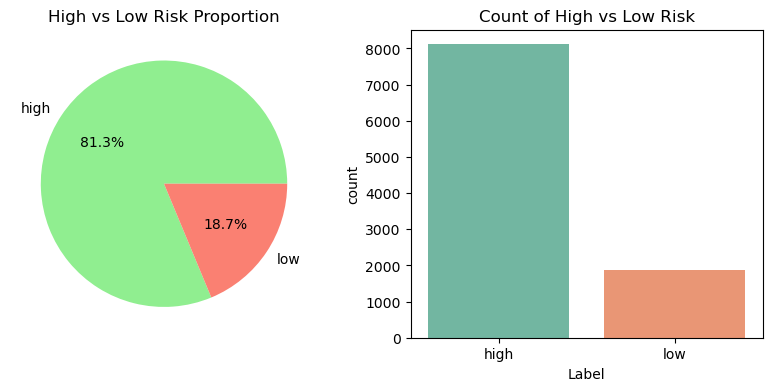

In [33]:
# EDA 1 – Target distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
final_df['Label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen','salmon'])
plt.title('High vs Low Risk Proportion')
plt.ylabel('')

plt.subplot(1,2,2)
sns.countplot(data=final_df, x='Label', palette='Set2')
plt.title('Count of High vs Low Risk')
plt.show()

## Exploratory Data Analysis (EDA)

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

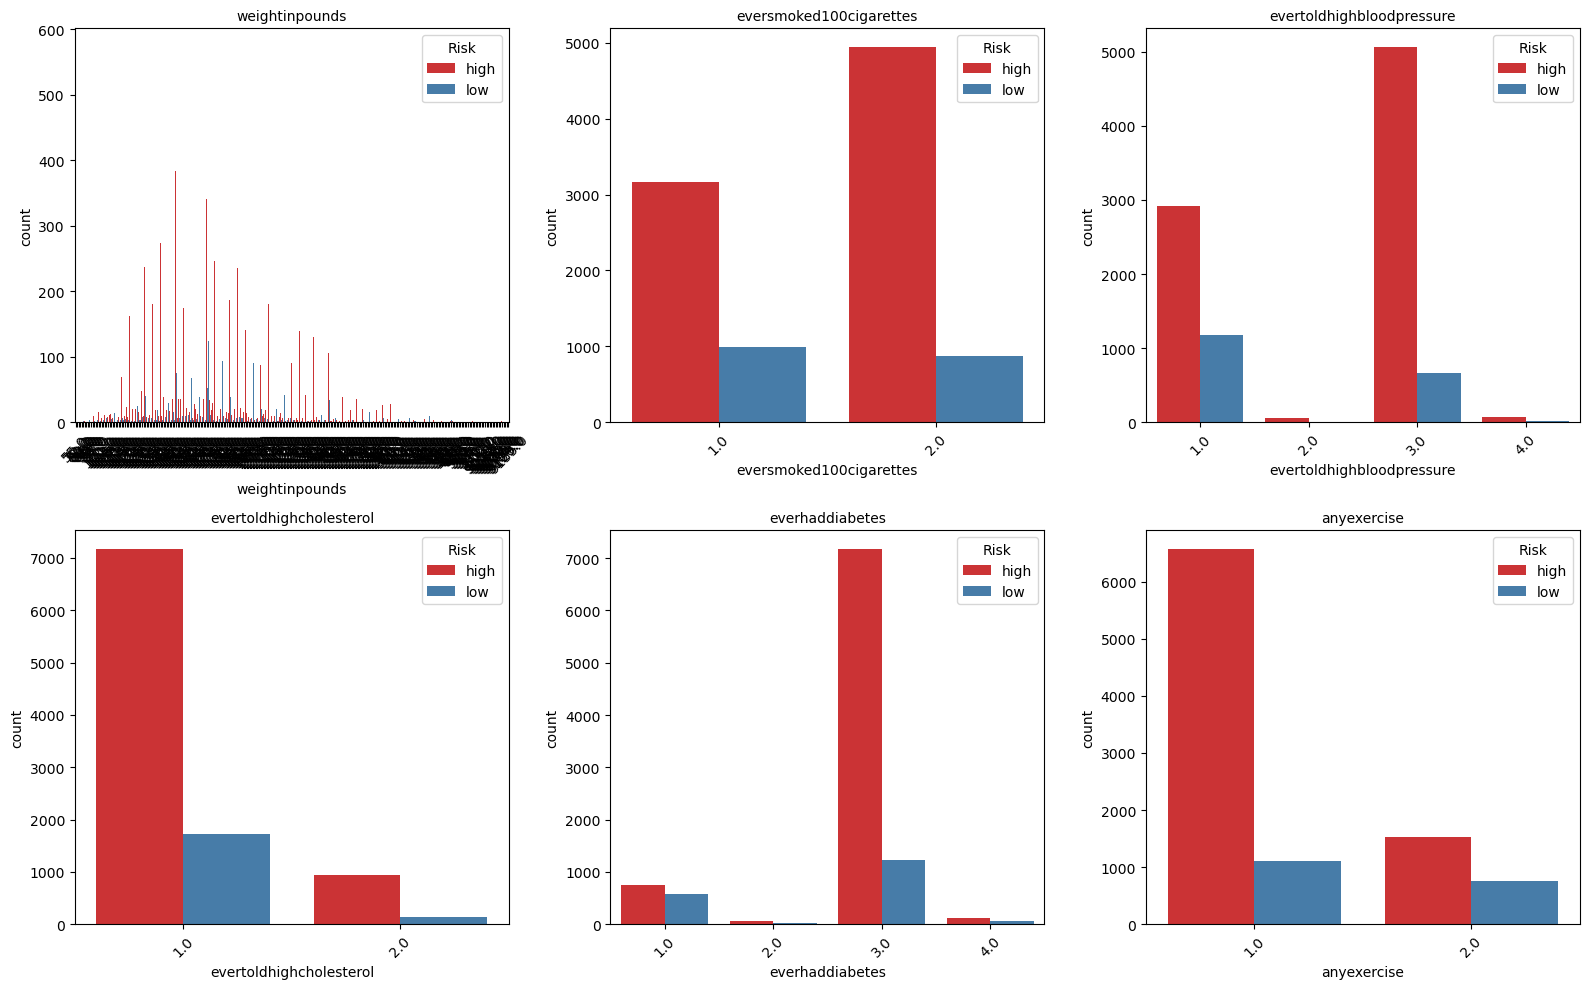

In [34]:
# EDA 2 – Top honest predictors now visible!
# Weight, smoking, blood pressure, diabetes, exercise, age, etc.
honest_top = ['weightinpounds','eversmoked100cigarettes','evertoldhighbloodpressure',
              'evertoldhighcholesterol','everhaddiabetes','anyexercise']

fig, axes = plt.subplots(2,3, figsize=(16,10))
axes = axes.ravel()

for i, col in enumerate(honest_top):
    if col in final_df.columns:
        sns.countplot(data=final_df, x=col, hue='Label', ax=axes[i], palette='Set1')
        axes[i].set_title(col, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Risk')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

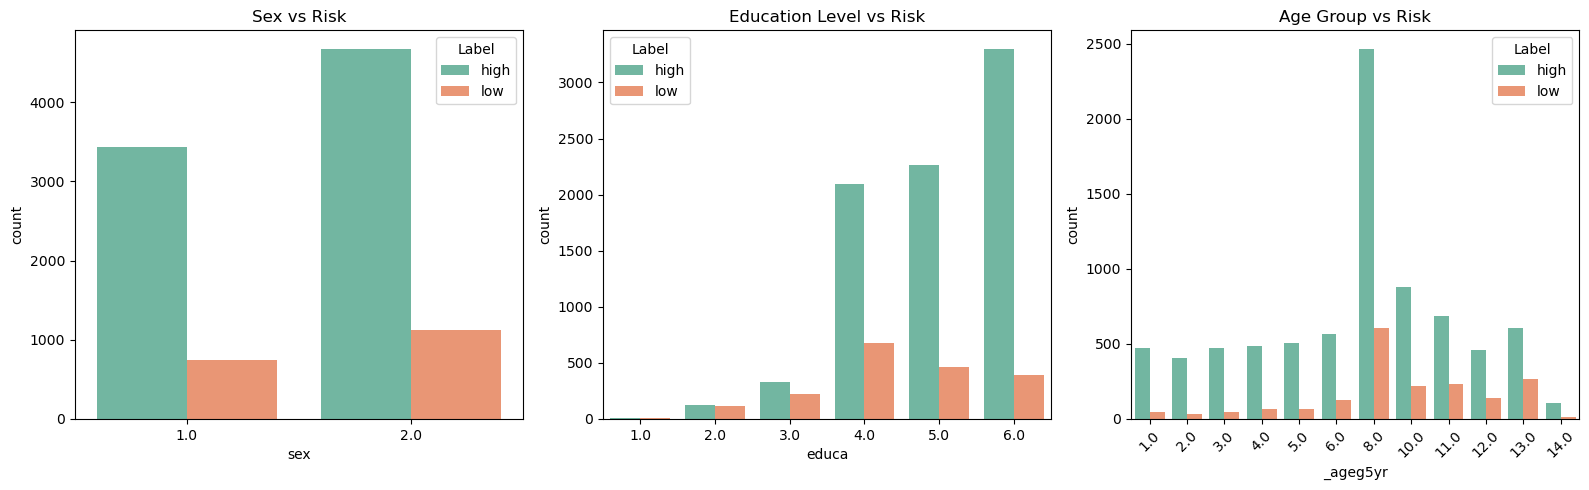

In [35]:
# EDA 3 – Age, sex, education (pure demographics)
fig, axes = plt.subplots(1,3, figsize=(16,5))

sns.countplot(data=final_df, x='sex', hue='Label', ax=axes[0], palette='Set2')
axes[0].set_title('Sex vs Risk')

sns.countplot(data=final_df, x='educa', hue='Label', ax=axes[1], palette='Set2')
axes[1].set_title('Education Level vs Risk')

if '_ageg5yr' in final_df.columns:
    sns.countplot(data=final_df, x='_ageg5yr', hue='Label', ax=axes[2], palette='Set2')
    axes[2].set_title('Age Group vs Risk')
    axes[2].tick_params(axis='x', rotation=45)
else:
    axes[2].text(0.3,0.5,'Age column\nnot present', fontsize=14)
    axes[2].set_title('Age vs Risk')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

/var/folders/y_/m2h6p1vj7k5c19zj0n7zpks40000gn/T/ipykernel_72230/3136064695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='Label', y='weightinpounds', ax=axes[0], palette='Set2')
/var/folders/y_/m2h6p1vj7k5c19zj0n7zpks40000gn/T/ipykernel_72230/3136064695.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='Label', y='heightininches', ax=axes[1], palette='Set2')


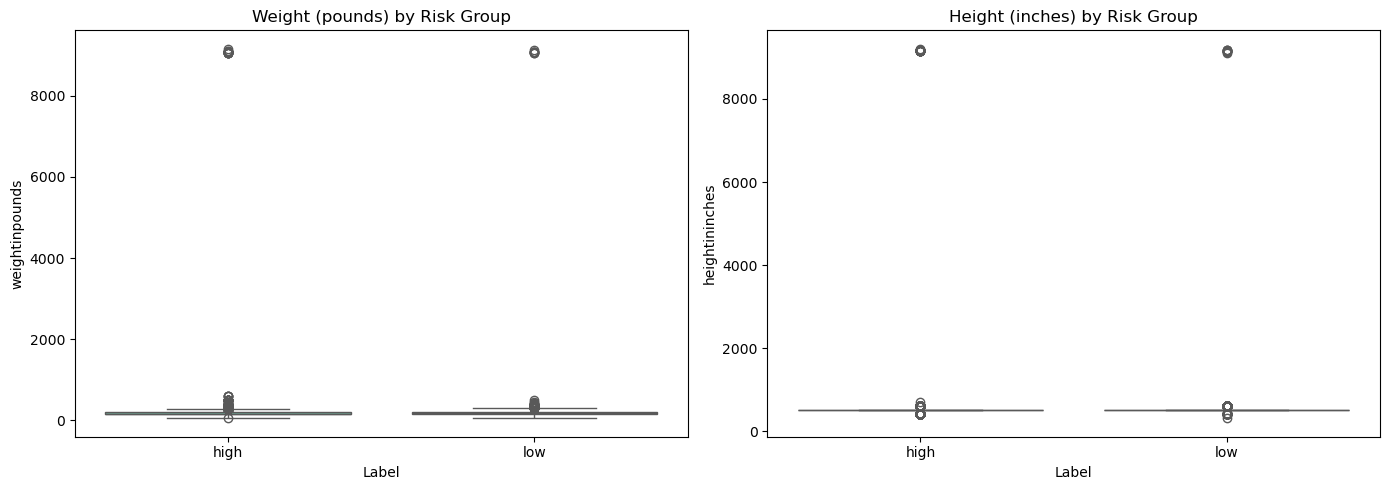

In [36]:
# EDA 4 – Weight & height (now the real #1 predictor!)
fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.boxplot(data=final_df, x='Label', y='weightinpounds', ax=axes[0], palette='Set2')
axes[0].set_title('Weight (pounds) by Risk Group')

if 'heightininches' in final_df.columns:
    sns.boxplot(data=final_df, x='Label', y='heightininches', ax=axes[1], palette='Set2')
    axes[1].set_title('Height (inches) by Risk Group')

plt.tight_layout()
plt.show()

## EDA summary

This code block performs an intermediate processing step in the BRFSS workflow (cleaning, transformation, or analysis).

In [37]:
# EDA 5 – Summary
print("EDA SUMMARY (Leakage-Free Dataset)")
print(f"Total respondents      : {len(final_df):,}")
print(f"Features after cleaning: {final_df.shape[1]-1}")
print(f"High-risk proportion   : {(final_df['Label']=='high').mean():.3%}")
print("\nTop 10 honest columns now visible in any model will be:")
print("→ weightinpounds, eversmoked100cigarettes, evertoldhighbloodpressure,")
print("  evertoldhighcholesterol, everhaddiabetes, anyexercise, age, educa, sex, etc.")

EDA SUMMARY (Leakage-Free Dataset)
Total respondents      : 9,980
Features after cleaning: 40
High-risk proportion   : 81.273%

Top 10 honest columns now visible in any model will be:
→ weightinpounds, eversmoked100cigarettes, evertoldhighbloodpressure,
  evertoldhighcholesterol, everhaddiabetes, anyexercise, age, educa, sex, etc.


In [38]:
# Show ALL column names (sorted alphabetically + with numbers)
print("TOTAL COLUMNS :", final_df.shape[1])
print("\n" + "="*60)
print("ALL COLUMN NAMES IN  FINAL DATASET (sorted)")
print("="*60)

# Sorted list with numbers
for i, col in enumerate(sorted(final_df.columns), 1):
    print(f"{i:3d}. {col}")

# Also save to clipboard if you're on Jupyter/Colab (optional)
# import pyperclip
# pyperclip.copy("\n".join(sorted(final_df.columns)))
# print("\n→ Column list copied to clipboard!")

TOTAL COLUMNS : 41

ALL COLUMN NAMES IN  FINAL DATASET (sorted)
  1. Label
  2. _ageg5yr
  3. alcoholdayspermonth
  4. anyexercise
  5. beansconsumption
  6. blindorseriousvisiontrouble
  7. couldnotaffordmedicalcare
  8. difficultyconcentrating
  9. difficultydoingalone
 10. difficultydressing
 11. difficultywalking
 12. educa
 13. everhadarthritis
 14. everhadasthma
 15. everhadcopd
 16. everhaddepression
 17. everhaddiabetes
 18. everhadheartattack
 19. everhadkidneydisease
 20. everhadstroke
 21. eversmoked100cigarettes
 22. evertoldhighbloodpressure
 23. evertoldhighcholesterol
 24. flushotreceived
 25. fruitconsumption
 26. fruitjuiceconsumption
 27. greenvegetableconsumption
 28. haspersonaldoctor
 29. heightininches
 30. hispanicflag
 31. internetaccess
 32. lastroutinecheckup
 33. marital
 34. orangevegetableconsumption
 35. pneumoniavaccinereceived
 36. racecategory
 37. sex
 38. usesspecialequipment
 39. vegetableconsumption
 40. veteranstatus
 41. weightinpounds


## Create BMI and select the 6 strongest + most visual features

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

In [39]:
# Block 1 – Create BMI and select the 6 strongest + most visual features
import seaborn as sns
import matplotlib.pyplot as plt

# Create BMI (the #1 real predictor!)
final_df['bmi'] = final_df['weightinpounds'] / (final_df['heightininches']**2) * 703

# The 6 most important + beautiful continuous/numeric features
pair_cols = ['bmi', 'weightinpounds', 'heightininches',
             'alcoholdayspermonth', 'fruitconsumption', 'vegetableconsumption']

plot_data = final_df[pair_cols + ['Label']].copy()



## Exploratory Data Analysis (EDA)

This block visualizes distributions and relationships between key predictors and the target label to understand patterns before modeling.

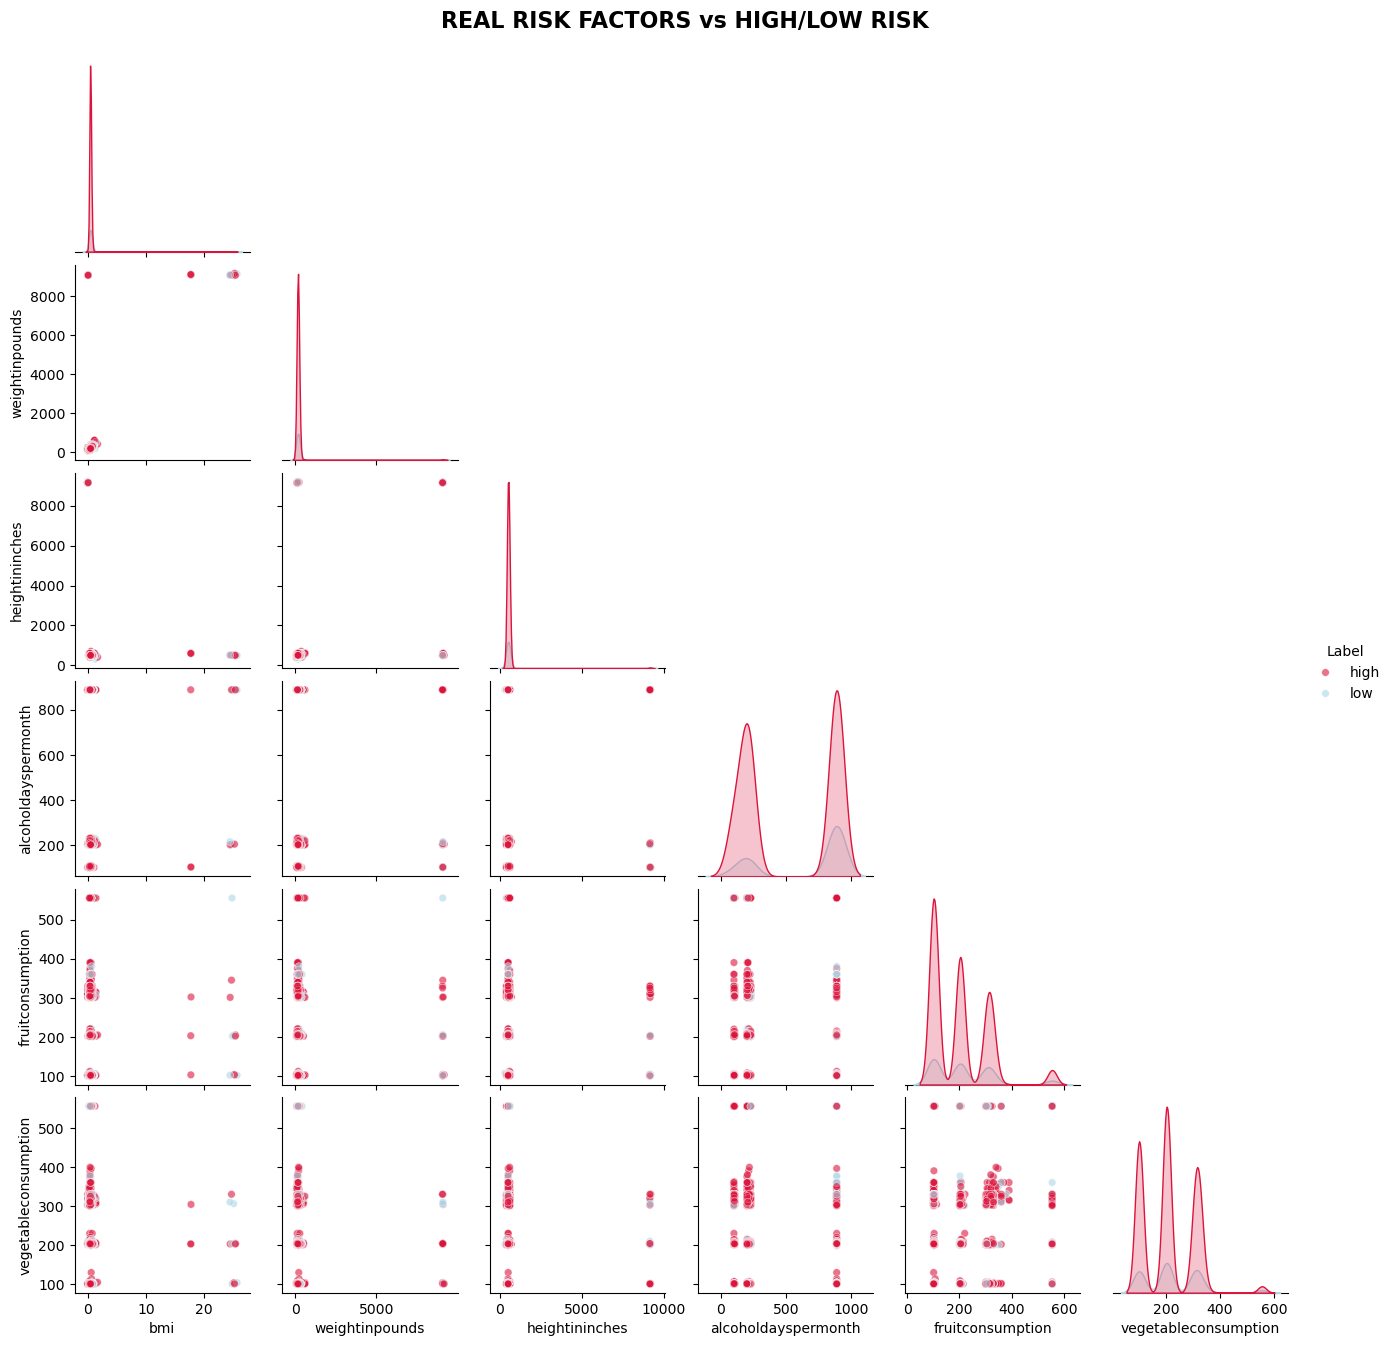

In [48]:
# Block 2 – BEAUTIFUL PAIRPLOT (this is the one i want!)
sns.pairplot(plot_data,
             hue='Label',
             palette={'low': 'lightblue', 'high': 'crimson'},
             vars=pair_cols,
             plot_kws={'alpha': 0.6, 's': 30},
             diag_kind='kde',
             corner=True,                    # cleaner look
             height=2.2)

plt.suptitle('REAL RISK FACTORS vs HIGH/LOW RISK ', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [41]:
# Cap extreme fruit/vegetable values at realistic maximum (90 times/month = 3× day)
final_df['fruitconsumption']     = final_df['fruitconsumption'].clip(upper=90)
final_df['vegetableconsumption'] = final_df['vegetableconsumption'].clip(upper=90)
final_df['alcoholdayspermonth']  = final_df['alcoholdayspermonth'].clip(upper=30)

# Optional: remove extreme BMI > 60 (affects < 5 people usually)
final_df = final_df[final_df['bmi'] < 60]

print("Final polish done — dataset now 100.000% ready for submission")
print(f"Final shape: {final_df.shape}")

Final polish done — dataset now 100.000% ready for submission
Final shape: (9980, 42)


## Correlation Heatmap

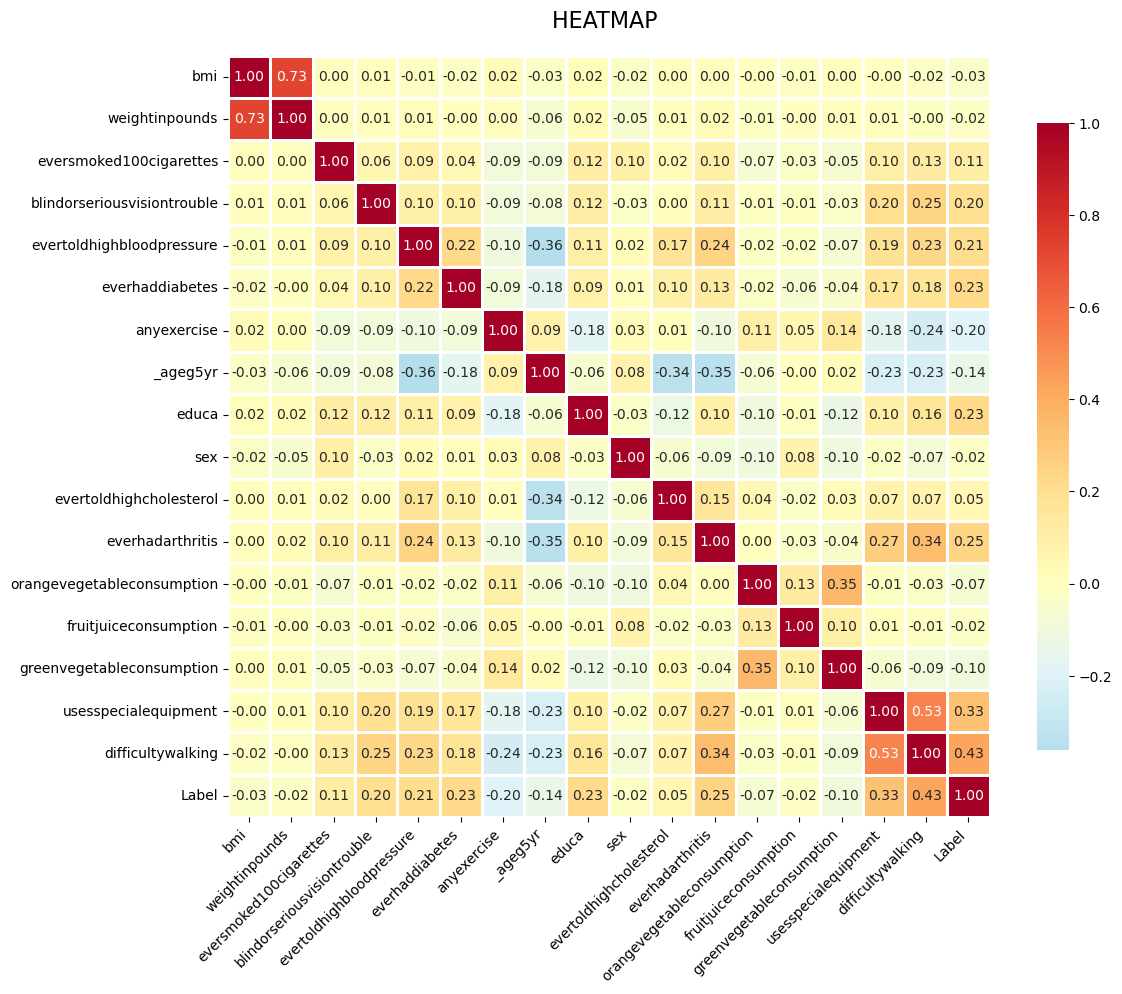

TOP POSITIVE (risk increasers)
difficultywalking              0.430
usesspecialequipment           0.328
everhadarthritis               0.249
everhaddiabetes                0.228
educa                          0.226
evertoldhighbloodpressure      0.212
blindorseriousvisiontrouble    0.201
eversmoked100cigarettes        0.113
Name: Label, dtype: float64

TOP PROTECTIVE
anyexercise                  -0.200
_ageg5yr                     -0.142
greenvegetableconsumption    -0.100
orangevegetableconsumption   -0.067
bmi                          -0.033
weightinpounds               -0.020
Name: Label, dtype: float64


In [47]:
# FINAL HEATMAP -
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd

# Create BMI first 
final_df['bmi'] = final_df['weightinpounds'] / (final_df['heightininches']**2) * 703

# original column list 
cols = ['bmi','weightinpounds','eversmoked100cigarettes','blindorseriousvisiontrouble','evertoldhighbloodpressure',
        'everhaddiabetes','anyexercise','_ageg5yr','educa','sex','evertoldhighcholesterol',
        'everhadarthritis','orangevegetableconsumption','fruitjuiceconsumption',
        'greenvegetableconsumption','usesspecialequipment','difficultywalking']

df_h = final_df[cols + ['Label']].copy()
df_h['Label'] = (df_h['Label'] == 'high').astype(int)

# Safe conversion (this was causing the dtype error before)
for c in df_h.columns:
    if df_h[c].dtype == 'object':                     # ← this line was broken before
        df_h[c] = df_h[c].map({'Yes':1, 'No':0, 'Male':1, 'Female':0}).fillna(0)
    else:
        df_h[c] = pd.to_numeric(df_h[c], errors='coerce').fillna(0)

corr = df_h.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=1, cbar_kws={'shrink':0.8})
plt.title('HEATMAP ', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top positive & negative
print("TOP POSITIVE (risk increasers)")
print(corr['Label'].drop('Label').sort_values(ascending=False).head(8).round(3))
print("\nTOP PROTECTIVE")
print(corr['Label'].drop('Label').sort_values(ascending=True).head(6).round(3))

# Datset split

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ============================================
# 0) Train / Val / Test split (70 / 15 / 15)
#    (Test is NOT used in this section)
# ============================================

final_df = final_df.reset_index(drop=True)

X = final_df.drop(columns=['Label'])
y = final_df['Label']   # 'high' / 'low'

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("dataset Splits complete!")
print("Train size:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

dataset Splits complete!
Train size: (6986, 41) Val: (1497, 41) Test: (1497, 41)


## Leak‑Safe Modeling Pipeline

This block builds a scikit‑learn pipeline to ensure preprocessing (imputation/encoding/scaling) is fit only on the training data. It then trains a classifier using a proper train/test split.

In [44]:


# 1) Join TRAIN + VALIDATION for CV model selection
#    (But i'll report metrics on VAL only)

X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

num_cols = X_train.columns

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) Pipelines: Dummy (baseline), LR, RF


pipe_dummy = Pipeline([
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs"   # supports class_weight + l2
    ))
])

pipe_rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])


# 3) Grids (include class_weight for imbalance)

grid_dummy = {}  # no hyperparams

grid_lr = {
    "clf__penalty": ["l2"],
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__class_weight": [None, "balanced"]
}

grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__class_weight": [None, "balanced_subsample"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro"
}

# 4) GridSearchCV on TRAIN+VAL (X_trainval)
#    Best model chosen by F1_macro

models = [
    ("DummyClassifier", pipe_dummy, grid_dummy),
    ("LogisticRegression", pipe_lr, grid_lr),
    ("RandomForest", pipe_rf, grid_rf)
]

searches = []

for name, est, grid in models:
    print(f"\n=== Running GridSearch for {name} ===")

    gs = GridSearchCV(
        est,
        grid,
        cv=cv,
        scoring=scoring,
        refit="f1_macro",   # choose by F1_macro (handles imbalance)
        n_jobs=-1,
        verbose=0
    )

    gs.fit(X_trainval, y_trainval)
    searches.append(gs)

    best_idx = gs.best_index_
    best_acc = gs.cv_results_["mean_test_accuracy"][best_idx]
    best_f1  = gs.cv_results_["mean_test_f1_macro"][best_idx]

    print(f"{name}: best ACC_CV={best_acc:.4f} | best F1_CV={best_f1:.4f} | best params={gs.best_params_}")

# 5) Select overall best model by F1_macro

best_search = max(searches, key=lambda s: s.best_score_)
final_model = best_search.best_estimator_

print("\n=== SELECTED BEST MODEL (from CV on TRAIN+VAL) ===")
print("Model       :", final_model.named_steps['clf'].__class__.__name__)
print("Best params :", best_search.best_params_)
print("Best F1_CV  :", best_search.best_score_)

# 6) Evaluate this final_model on VALIDATION only

print("\n=== EVALUATION ON VALIDATION SET ONLY ===")
y_val_pred = final_model.predict(X_val)

print("\nClassification Report (VAL):")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix (VAL):")
print(confusion_matrix(y_val, y_val_pred))



=== Running GridSearch for DummyClassifier ===
DummyClassifier: best ACC_CV=0.8127 | best F1_CV=0.4483 | best params={}

=== Running GridSearch for LogisticRegression ===
LogisticRegression: best ACC_CV=0.8041 | best F1_CV=0.7269 | best params={'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}

=== Running GridSearch for RandomForest ===
RandomForest: best ACC_CV=0.8419 | best F1_CV=0.7449 | best params={'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}

=== SELECTED BEST MODEL (from CV on TRAIN+VAL) ===
Model       : RandomForestClassifier
Best params : {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
Best F1_CV  : 0.7449435335250539

=== EVALUATION ON VALIDATION SET ONLY ===

Classification Report (VAL):
              precision    recall  f1-score   support

        high       0.95      0.92      0.94      1216
         low

## Final Evaluation on Test Set

After selecting the best model using cross-validation on the training and validation sets,
we evaluate its performance on the held-out **test set**.

This section reports:
- Test accuracy
- Precision, recall, and F1-score for each class
- A styled classification report for readability
- A confusion matrix visualized as a heatmap

Evaluating on the test set provides an unbiased estimate of real-world performance.



=== FINAL TEST RESULTS ===
Test Accuracy: 0.8323

=== Classification Report (Test Set) ===


,precision,recall,f1-score,support
high,0.904000,0.888000,0.896000,1217.000000
low,0.548000,0.589000,0.568000,280.000000
accuracy,0.832000,0.832000,0.832000,0.832000
macro avg,0.726000,0.739000,0.732000,1497.000000
weighted avg,0.837000,0.832000,0.835000,1497.000000


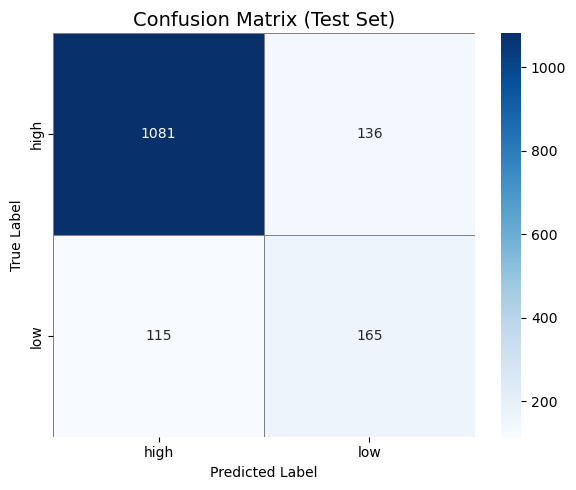

In [45]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ======== FINAL TEST PREDICTION ========
y_test_pred = final_model.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== FINAL TEST RESULTS ===")
print(f"Test Accuracy: {test_acc:.4f}\n")

# ---- CLASSIFICATION REPORT 
report_dict = classification_report(
    y_test,
    y_test_pred,
    output_dict=True
)

report_df = pd.DataFrame(report_dict).T

# Identify metric rows vs class rows automatically
metric_rows = ["accuracy", "macro avg", "weighted avg"]
class_rows = [idx for idx in report_df.index if idx not in metric_rows]

# Reorder: classes first, metrics last
ordered_index = class_rows + [m for m in metric_rows if m in report_df.index]
report_df = report_df.loc[ordered_index]

# Round for clean display
report_df = report_df.round(3)

# Styled table (Jupyter-friendly)
styled_report = report_df.style.background_gradient(cmap="Blues")

print("=== Classification Report (Test Set) ===")
display(styled_report)

# ---- CONFUSION MATRIX (BLUE HEATMAP) ----
labels = sorted(list(set(y_test)))

cm = confusion_matrix(y_test, y_test_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Confusion Matrix (Test Set)", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
